In [1]:
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('seaborn-paper')
import cmocean

ModuleNotFoundError: No module named 'cmocean'

In [50]:
#---------------------------------------
# Example: Simple flow past a cylinder
# Load Data
#---------------------------------------
data = np.load("data/flow_cylinder.npy")
# Split into train and test set
t, m, n = data.shape
X = data.reshape(151,-1)
print(data.shape)
# Center data
#X -= np.mean(X, axis=0)
N_time_step = 151
dt = 0.2
X = X.T 

(151, 449, 199)


In [51]:
def plot_flow(X, m, n):
    X = X.reshape(m,n)
    mX, mY = np.meshgrid(np.arange(0, m, 1), np.arange(0, n, 1))
    minmax = np.max(np.abs(X)) * 0.85
    im = plt.imshow(X.T, cmap=cmocean.cm.balance, interpolation='bicubic', vmin=-minmax, vmax=minmax)
    # plot flow
    plt.contourf(mX, mY, X.T, 90, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax, vmax=minmax)
    # plot cylinder
    circ=plt.Circle((50,99), radius=30, color='#636363', fill=True)
    im.axes.add_patch(circ)
    # mute axis
    plt.axis('off')
    plt.tight_layout()

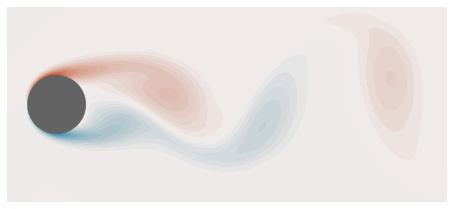

In [52]:
plot_flow(X[:,0], m, n)

In [53]:
# classical dmd   
def toy_dmd(Xleft, Xright, k, dt=1): 
    # compute svd
    U, s, Vt = np.linalg.svd(Xleft, False)
    
    # truncate
    U = U[:,0:k]
    s = s[0:k]
    Vt = Vt[0:k,:]

    G = np.dot(Xright, Vt.T) / s
    M = np.dot(U.T, G)

    # Eigen Decomposition
    eigs, w = np.linalg.eig(M)
    omega = np.log(eigs) / dt    
    
    dmd_modes = Xright.dot(Vt.T.dot(np.diag(s**-1)).dot(w))
    
    sort_idx = np.argsort(np.abs(omega))
    dmd_modes = dmd_modes[:, sort_idx]
    omega = omega[sort_idx]      
    eigs = eigs[sort_idx]      
    
    
    return eigs, dmd_modes

In [54]:
X.shape

(89351, 151)

In [55]:
#DMD Approximation
eigs_approx, dmd_modes = toy_dmd(X[:, :-1], X[:, 1:], k=10, dt=dt)

In [56]:
#eigs_approx = np.exp(eigs_approx)

In [57]:
def plot_eig(eig):
    fig = plt.figure(figsize=(6.1, 6.1))
    plt.scatter(eig.real, eig.imag, c = 'red', marker = 'o', s=15*6, zorder=2, label='Approx Eigenvalues')
    plt.legend()
    maxeig = 1.4
    #plt.xlim([-maxeig, maxeig])
    #plt.ylim([-maxeig, maxeig])
    plt.locator_params(axis='x',nbins=4)
    plt.locator_params(axis='y',nbins=4)

    plt.xlabel('Real', fontsize=22)
    plt.ylabel('Imaginary', fontsize=22)
    plt.tick_params(axis='y', labelsize=22)
    plt.tick_params(axis='x', labelsize=22)
    plt.axhline(y=0,color='#636363',ls='-', lw=3, zorder=1 )
    plt.axvline(x=0,color='#636363',ls='-', lw=3, zorder=1 )

    t = np.linspace(0,np.pi*2,100)
    plt.plot(np.cos(t), np.sin(t), ls='-', lw=3, c = '#636363', zorder=1 )
    plt.title('Estimated eigs')
    plt.tight_layout()
    plt.show()

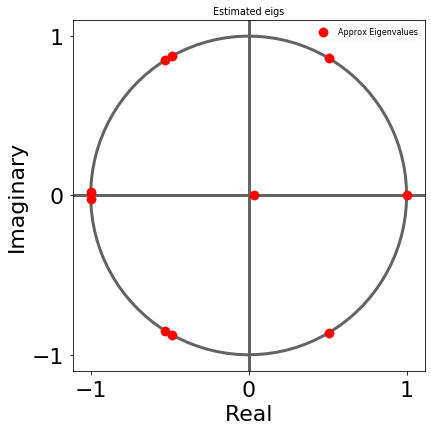

In [58]:
plot_eig(eigs_approx)

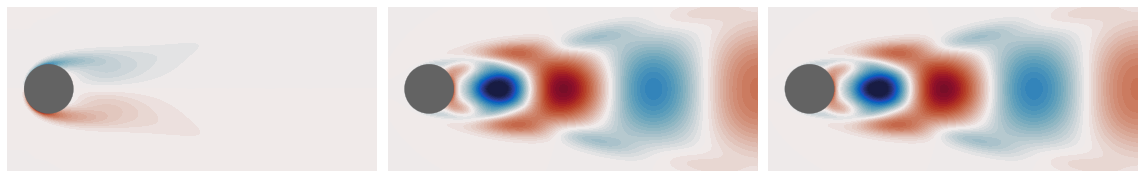

In [59]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plot_flow(dmd_modes[:,0].real, m, n)
plt.subplot(1,3,2)
plot_flow(dmd_modes[:,1].real, m, n)
plt.subplot(1,3,3)
plot_flow(dmd_modes[:,2].real, m, n)

In [60]:
#Traditional bootstrap on eigenvalues of DMD with nboots trials
def eig_bootstrap(X, nboots=10, k=1):
    eig_boot = []    
    for i in range(nboots):
        idx = np.random.choice(range(X.shape[1]-1), X.shape[1]-1, True)
        idx = np.sort(idx)
        Xleft , Xright = X[:,idx], X[:,idx+1]
        eigs, _, = toy_dmd(Xleft, Xright, k=k)
        eig_boot.append(eigs)
    eig_boot = np.asarray(eig_boot)
    return eig_boot

In [61]:
#Moving block bootstrap method, nboot trials; data is split into n − b + 1 overlapping blocks of length
def block_bootstrap(X, nboots=10, k=1):
    #Generating blocks
    n = X.shape[1]
    l = round(2*n**(1/3))
    N = n-l+1
    block = []
    for i in range(N-1):
        block.append(range(i, i+l))
    b = n//l
    eig_boot = []
    for i in range(nboots):
        idb = np.random.choice(range(len(block)), b, True)
        idx = np.sort([x for i in idb for x in block[i]])
        Xleft, Xright = X[:, idx], X[:, idx+1]
        eigs, _, = toy_dmd(Xleft, Xright, k=k)
        eig_boot.append(eigs)
    eig_boot = np.asarray(eig_boot)
    return eig_boot

In [82]:
eig_boot = eig_bootstrap(X, nboots=10, k=3)

In [86]:
eig_block_boot = block_bootstrap(X, nboots=10, k=3)

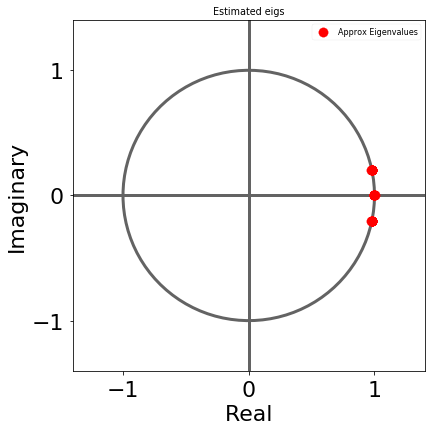

In [87]:
plot_eig(eig_boot)

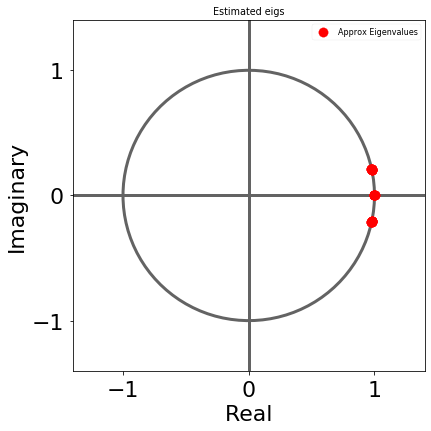

In [88]:
plot_eig(eig_block_boot)

In [89]:
def percentile (data, ci=90):
    low = np.percentile(data, 5, axis=0)
    high = np.percentile(data, 95, axis=0)
    mean = np.percentile(data, 50, axis=0)
    return low, high, mean

In [93]:
low_real, high_real, mean_real = percentile(eig_boot.real)
low_imag, high_imag, mean_imag = percentile(eig_boot.imag)
low, high, mean = percentile(eig_boot)

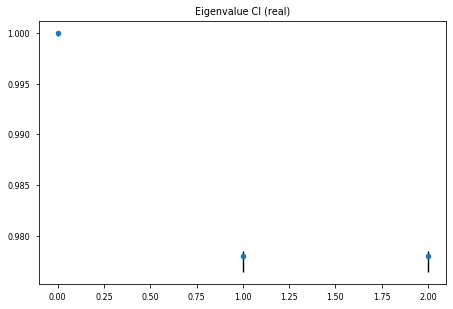

In [94]:
#Plot the 90% confidence interval of the real part of bootstrapped eigenvalues
plt.figure()
plt.vlines(range(eig_boot.real.shape[1]), low_real, high_real)
plt.plot(range(eig_boot.real.shape[1]), mean_real, 'o')
plt.title('Eigenvalue CI (real)')
plt.tight_layout()
plt.show()

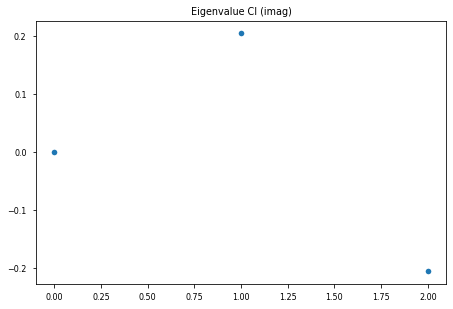

In [95]:
#Plot the 90% confidence interval of the imaginary part of bootstrapped eigenvalues
plt.figure()
plt.vlines(range(eig_boot.imag.shape[1]), low_imag, high_imag)
plt.plot(range(eig_boot.imag.shape[1]), mean_imag, 'o')
plt.title('Eigenvalue CI (imag)')
plt.tight_layout()
plt.show()

In [98]:
def ploy_est_dyn(k):
    dyn = []
    for i in range(eig_boot.shape[0]):
        dyn.append(np.vander(np.array([eig_boot[i,k]]),100, increasing=True).flatten(-1))
    dyn = np.asarray(dyn)

    low_dyn, high_dyn, mean_dyn = percentile(dyn)

    #Plot Estimated Dynamics
    plt.figure()
    plt.plot(range(100), mean_dyn.flatten(-1))
    plt.fill_between(range(100), low_dyn.flatten(-1), high_dyn.flatten(-1), facecolor='b', color='#de2d26', alpha=0.5)
    plt.title('Estimated dynamics')
    plt.tight_layout()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  if sys.path[0] == '':


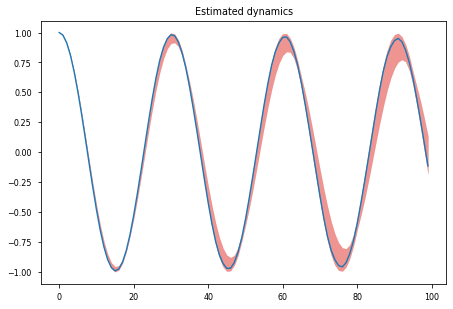

In [99]:
ploy_est_dyn(2)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  if sys.path[0] == '':


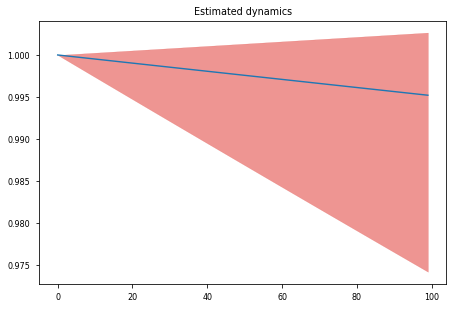

In [100]:
ploy_est_dyn(0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  if sys.path[0] == '':


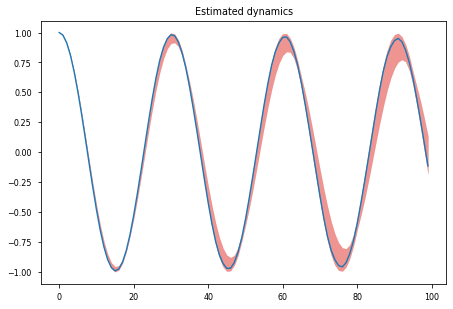

In [101]:
ploy_est_dyn(1)